In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm

In [2]:
results_dir = Path("/home/alexander/projects/car_data_analysis/results/ensemble")
runtimes = dict()
results = pd.DataFrame()

for exp_folder in tqdm(list(results_dir.glob("*"))):
    if exp_folder.is_dir():
        exp = exp_folder.stem
        for method_folder in exp_folder.glob("*"):
            method = method_folder.stem
            # One file per method
            for file in method_folder.glob("*.csv"):
                runtime = file.stem.split("_")[-1]
                this_results = pd.read_csv(file)
                this_results["method"] = method
                this_results["exp"] = exp
                if method in runtimes:
                    runtimes[method].append(runtime)
                else:
                    runtimes[method] = list(runtime)
                results = pd.concat((results, this_results))

100%|██████████| 37/37 [01:44<00:00,  2.83s/it]


In [3]:
results

,id,price,prediction,test,method,exp
0,0-0,800,893.921881,0,RF,11
1,0-100,850,1023.904803,0,RF,11
2,0-101,799,1143.492790,0,RF,11
3,0-102,799,924.607378,0,RF,11
4,0-103,795,1091.115807,0,RF,11
...,...,...,...,...,...,...
34826,1-184,1600,2463.081300,1,NN,3
34827,49-110,3250,4009.843000,1,NN,3
34828,46-174,2950,3071.288000,1,NN,3
34829,124-168,2875,1924.661500,1,NN,3


In [5]:
overall = results
overall["exp"] = pd.to_numeric(overall["exp"])
overall = overall[overall["price"] < 11000] # Remove extremes for now (missed it earlier)
overall = overall[overall["exp"] != 0] # Exp 0 doesnt have CNN
overall = overall[overall["exp"] != 4] # Exp 4 has no LM or RF
overall = overall[overall["method"] != "CNN"] # CNN doesnt look great
# Comment/uncomment to control what makes it into ensemble
# overall = overall[overall["method"] != "NN"]
# overall = overall[overall["method"] != "LM"]
# overall = overall[overall["method"] != "GLM"]
overall = overall[overall["method"] != "NLP"]


In [6]:
# All ids from every experiment per aggregate
def _r_sq(y_true, y_pred):
    SST = sum((y_true-y_true.mean())**2)
    SSR = sum((y_true-y_pred)**2)
    return (1 - SSR/SST)

def _mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_pred)

def _mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_pred)

## Get weights of accuracy from training data only

In [7]:
train = overall[overall["test"] == 0]
test = overall[overall["test"] == 1]

# Aggregating id
grouped = train.groupby(["exp","method"])

# These are metrics per experiment per method
metrics = dict()
metrics["mse"] = grouped.apply(lambda x: _mse(x["price"], x["prediction"]) )
metrics["mae"] = grouped.apply(lambda x: _mae(x["price"], x["prediction"]) )
metrics["rsq"] = grouped.apply(lambda x: _r_sq(x["price"], x["prediction"]) )
metrics["mse"]

exp  method
1    GLM       2.149806e+06
     LM        2.396669e+06
     NN        1.743274e+06
     RF        5.071370e+05
2    GLM       2.131820e+06
                   ...     
28   RF        5.138849e+05
29   GLM       2.105325e+06
     LM        2.416427e+06
     NN        1.803913e+06
     RF        5.190465e+05
Length: 112, dtype: float64

In [8]:
# weigh inversely to error
weights = dict()
for metric in ["mae"]:
    for alpha in np.linspace(500, 10e3, 10):
        # Should be doing this alpha tuning on the test sets also imo
        tmp = metrics[metric].groupby("exp").transform(lambda x: alpha/x)
        # Softmax so we weigh to 1
        if metric not in weights:
            weights[metric] = dict()
        weights[metric][round(alpha)] = tmp.groupby("exp").transform(lambda x: np.exp(x)/sum(np.exp(x)))
weights["mae"]

{500: exp  method
 1    GLM       0.214940
      LM        0.210878
      NN        0.224397
      RF        0.349785
 2    GLM       0.215336
                  ...   
 28   RF        0.348672
 29   GLM       0.216536
      LM        0.211749
      NN        0.224352
      RF        0.347363
 Length: 112, dtype: float64,
 1556: exp  method
 1    GLM       0.130974
      LM        0.123426
      NN        0.149750
      RF        0.595851
 2    GLM       0.132145
                  ...   
 28   RF        0.592067
 29   GLM       0.135131
      LM        0.126051
      NN        0.150893
      RF        0.587924
 Length: 112, dtype: float64,
 2611: exp  method
 1    GLM       0.062990
      LM        0.057017
      NN        0.078874
      RF        0.801118
 2    GLM       0.064223
                  ...   
 28   RF        0.796765
 29   GLM       0.067145
      LM        0.059746
      NN        0.080805
      RF        0.792304
 Length: 112, dtype: float64,
 3667: exp  method
 1    GLM 

## Ensembling

In [9]:
eval_data = train

grouped = eval_data.groupby(["id", "exp"])

mean_ensemble = grouped.agg({
    'price' : 'mean',
    'prediction' : 'mean', # This is where we apply ensembling scheme
    'method' : 'count',
})
# For checking if all experiments worked
# set(mean_ensemble[mean_ensemble["method"] < 6].index.get_level_values("exp"))

In [10]:
w_weights = test.copy()
w_weights["weighted_prediction"] = 0

In [11]:
mae_weighted = list()
for scale, series in tqdm(weights["mae"].items()):
    # Join weights to correct experiment and method
    w_weights = pd.merge(eval_data, pd.DataFrame({"weight":series}), 
                                 how="left",
                                 left_on=["exp", "method"],
                                right_on=["exp", "method"])
    # Get weighted prediction
    w_weights["weighted_prediction"] = w_weights["prediction"]*w_weights["weight"]
    weighted_ensemble = w_weights.groupby(["exp","id"]).agg({
    'price' : 'mean',
    'prediction' : 'mean',
    'weighted_prediction' : 'sum', # This is where we apply ensembling scheme, weighting will add to 1
    'method' : 'count',
    })
    
    # Get MSE of weighted predictions
    mae_res = weighted_ensemble.groupby("exp").apply(lambda x: _mae(x["price"], x["weighted_prediction"]))
    mae_weighted.append((scale, mae_res, weighted_ensemble))

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


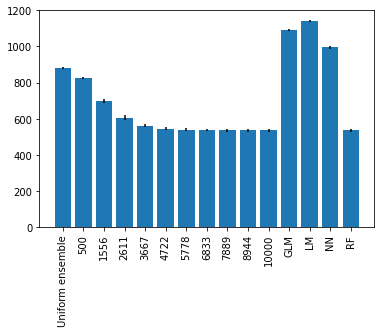

In [12]:
mae_me = mean_ensemble.groupby("exp").apply(lambda x: _mae(x["price"], x["prediction"]))
mae_iso = eval_data.groupby(["exp","method"]).apply(lambda x: _mae(x["price"], x["prediction"]) )

bars = ["Uniform ensemble", *[int(x[0]) for x in mae_weighted], *mae_iso.mean(level="method").keys()]
pos = range(len(bars))
height = [mae_me.mean(), *[x[1].mean() for x in mae_weighted], *mae_iso.mean(level="method").to_list()]
errs = [mae_me.std(), *[x[1].std() for x in mae_weighted], *mae_iso.std(level="method").to_list()]
plt.bar(pos, height, yerr=errs)
plt.xticks(pos, bars, rotation=90)
plt.show()

In [13]:
methods = mae_iso.mean(level="method").keys()
mae_weighted

[(500,
  exp
  1     824.521648
  2     823.815221
  3     827.083222
  5     823.118606
  6     826.979301
  7     840.643351
  8     818.310312
  9     825.709581
  10    819.457559
  11    832.543153
  12    822.053002
  13    839.340276
  14    826.637266
  15    839.871256
  16    828.309287
  17    824.233475
  18    824.308003
  19    822.620494
  20    833.566018
  21    823.051095
  22    814.185775
  23    820.932284
  24    828.726837
  25    815.500259
  26    835.673247
  27    822.203128
  28    823.082187
  29    829.890196
  dtype: float64,
             price   prediction  weighted_prediction  method
  exp id                                                    
  1   0-10     795  1128.610622          1113.474020       4
      0-100    850  1615.418367          1530.282655       4
      0-104    995  1301.651788          1267.610313       4
      0-105   1000   798.709868           858.486353       4
      0-107    900  1492.094091          1431.732052       4
  ...     

Text(0.5, 0, '$\\alpha$')

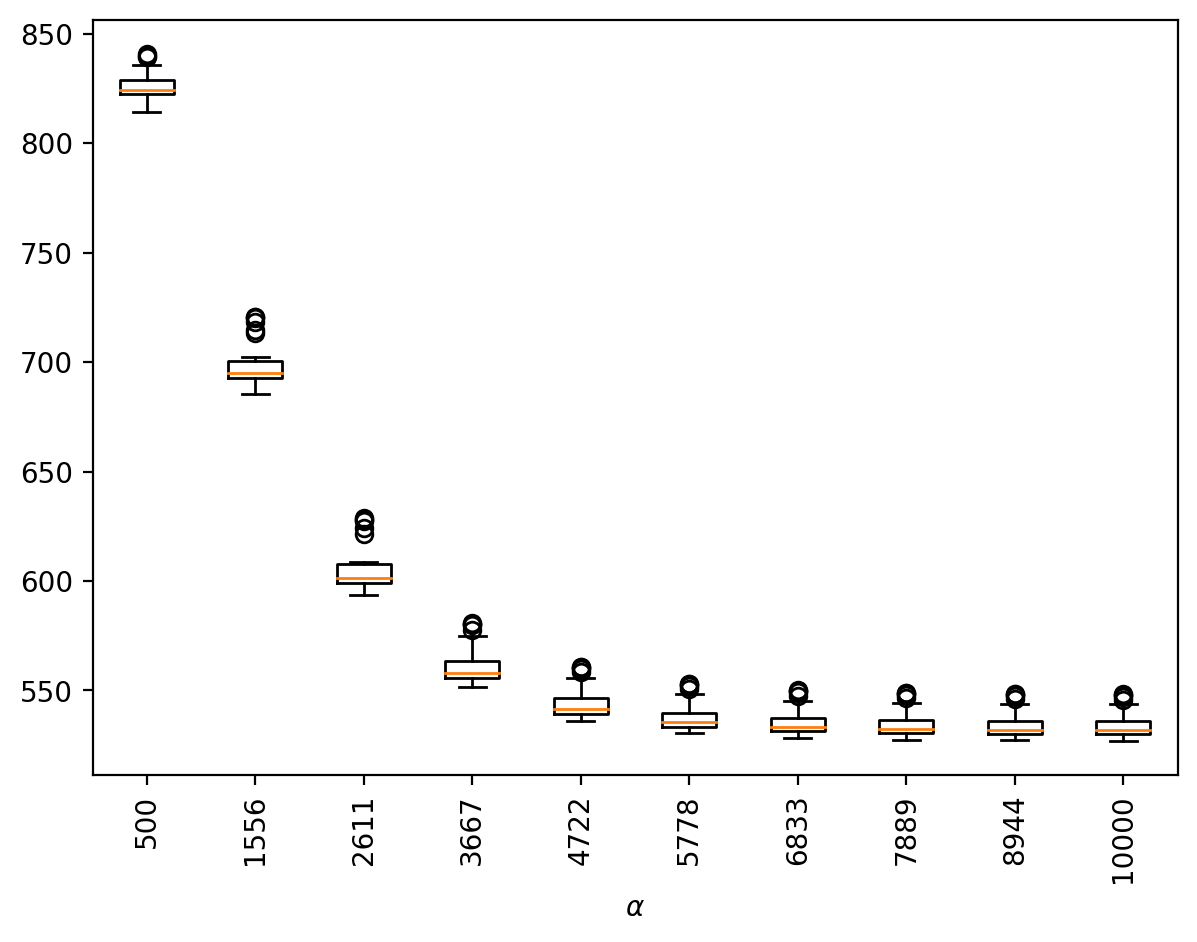

In [14]:
vals = [x[1].to_list() for x in mae_weighted]
labels = [int(x[0]) for x in mae_weighted]
labels = [round(x) for x in labels]
plt.figure(figsize=(7,5), dpi=200)
plt.boxplot(vals, labels=labels)
pos = range(1,len(vals)+1)
plt.xticks(pos, labels, rotation=90)
plt.xlabel(r"$\alpha$")
# plt.savefig("finding_best_weighting.png")

In [15]:
list(zip(height, labels))

[(881.8862143009306, 500),
 (826.298787123661, 1556),
 (699.1538162749706, 2611),
 (606.5317522682656, 3667),
 (562.2356807468112, 4722),
 (544.9867167912099, 5778),
 (538.5896490806442, 6833),
 (536.2074634890402, 7889),
 (535.3111173512268, 8944),
 (534.9711823782036, 10000)]

In [16]:
eval_data = test

w_weights = pd.merge(eval_data, pd.DataFrame({"weight":weights["mae"][4722]}), 
                                 how="left",
                                 left_on=["exp", "method"],
                                right_on=["exp", "method"])
# Get weighted prediction
w_weights["weighted_prediction"] = w_weights["prediction"]*w_weights["weight"]
weighted_ensemble = w_weights.groupby(["exp","id"]).agg({
'price' : 'mean',
'prediction' : 'mean',
'weighted_prediction' : 'sum', # This is where we apply ensembling scheme, weighting will add to 1
'method' : 'count',
})

grouped = eval_data.groupby(["id", "exp"])

mean_ensemble = grouped.agg({
    'price' : 'mean',
    'prediction' : 'mean', # This is where we apply ensembling scheme
    'method' : 'count',
})

# Get MSE of weighted predictions
mae_res = weighted_ensemble.groupby("exp").apply(lambda x: _mae(x["price"], x["weighted_prediction"]))
mae_me = mean_ensemble.groupby("exp").apply(lambda x: _mae(x["price"], x["prediction"]))
mae_iso = eval_data.groupby(["exp","method"]).apply(lambda x: _mae(x["price"], x["prediction"]) )

In [17]:
rf = eval_data.groupby(["method","id"]).mean().loc["RF"]
# best_models = [mse_res, mse_me, rf]
best_models = [rf, mean_ensemble, mse_res]

NameError: name 'mse_res' is not defined

In [19]:
bars = ["Uniform ensemble", "Weighted ensemble" ,*mae_iso.mean(level="method").keys()]
pos = range(len(bars))
height = [mae_me.mean(), mae_res.mean(), *mae_iso.mean(level="method").to_list()]
errs = [mae_me.std(), mae_res.std(), *mae_iso.std(level="method").to_list()]

[966.9877323308663,
 905.9860703924381,
 1092.8135452927118,
 1145.3080304598657,
 1000.6414779096657,
 908.8017735573596]

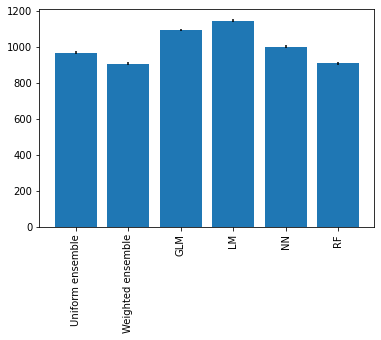

In [20]:
plt.bar(pos, height, yerr=errs)
plt.xticks(pos, bars, rotation=90)
height

In [21]:
((height[-1] - height[1])/height[-1])

0.003098258879821372

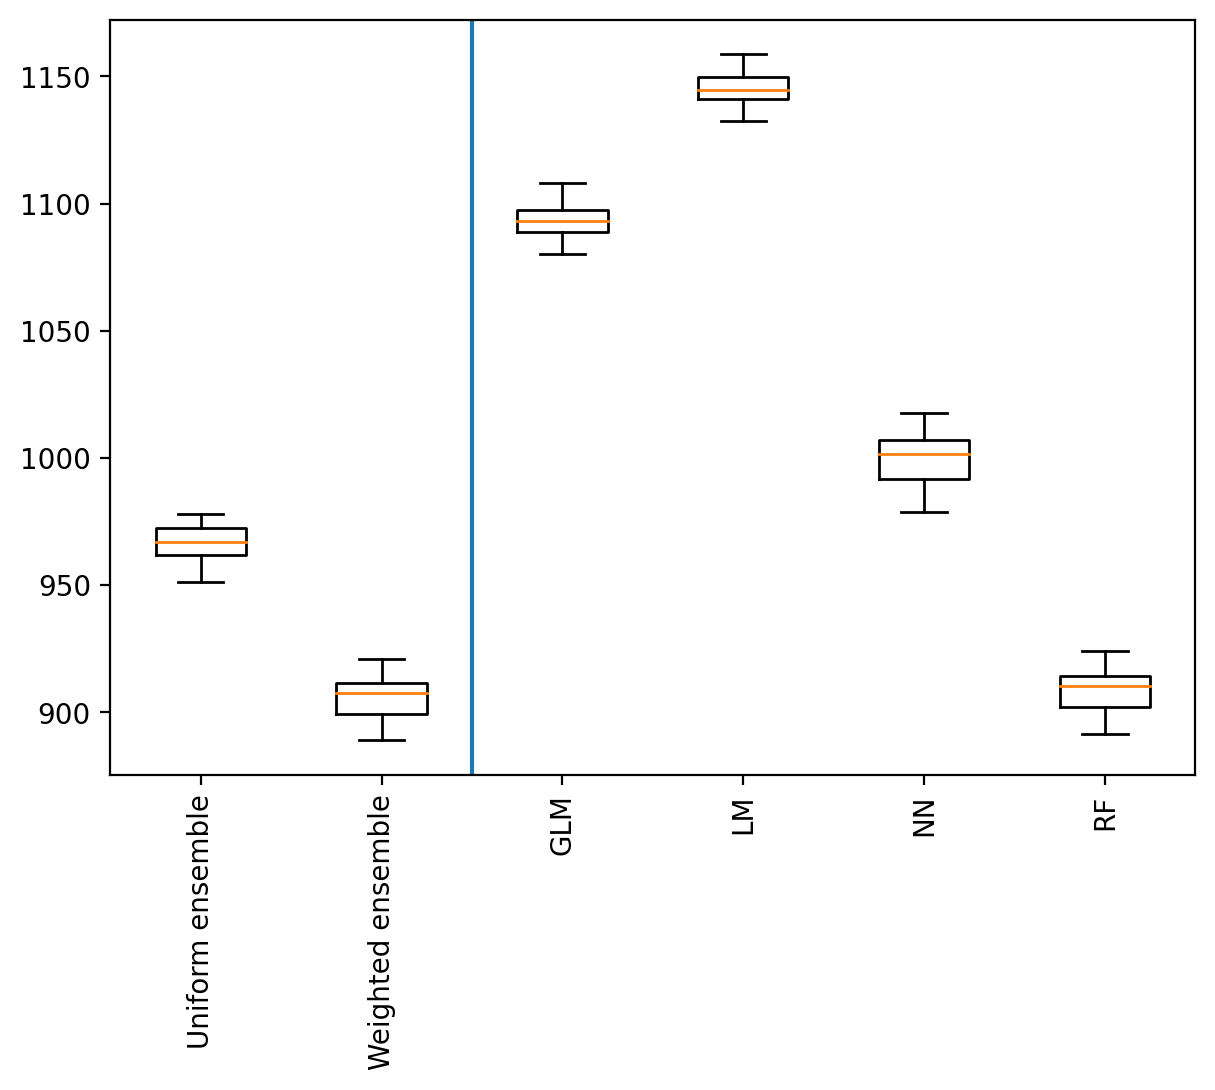

In [23]:
vals = [mae_me.to_list(), mae_res.to_list(), *[mae_iso.loc[:,method].to_list() for method in methods]]
labels = ["Uniform ensemble", "Weighted ensemble", *methods]

plt.figure(figsize=(7,5), dpi=200)
plt.boxplot(vals, labels=labels)
plt.axvline(2.5)
pos = range(1,len(vals)+1)
plt.xticks(pos, bars, rotation=90)
plt.savefig("weighted_ensemble_no_nlp_tested.png")